## Data Exploration

In [2]:

s3_bucket_path="s3://aegovan-data/human_output/human_keyinteractions.json"


In [3]:
import boto3

def download_single_file(bucket_name_path, local_path):
    index = bucket_name_path.find("://")

    # remove the s3:// if present
    if index > -1:
        bucket_name_path = bucket_name_path[index + 3:]

    key_start_index = bucket_name_path.find("/")
    bucket_name = bucket_name_path
    key = "/"
    if key_start_index > -1:
        bucket_name = bucket_name_path[0:key_start_index]
        key = bucket_name_path[key_start_index + 1:]
        
    client = boto3.resource('s3')
    client.Bucket(bucket_name).download_file(key, local_path)


In [4]:
data_file="input_data.json"


In [5]:
download_single_file(s3_bucket_path, data_file)

In [115]:

import pandas as pd

data = pd.read_json(data_file)

print("Total number of records: {}".format(data.shape[0]))

Total number of records: 3381


### Sneak preview of the data

In [116]:
#TODO: Fix data format
data["pubmedId"] = data["pubmedId"].astype(str)

In [8]:
data.head(n=3)

,interactionId,interactionType,isNegative,participants,pubmedId,pubmedTitle,pubmedabstract
0,2503510,phosphorylation,false,"[{'uniprotid': 'P43405', 'alias': [['ksyk_huma...",25605870,None,NLRP3 is the most crucial member of the NLR fa...
1,2503513,phosphorylation,false,"[{'uniprotid': 'P43405', 'alias': [['ksyk_huma...",25605870,None,NLRP3 is the most crucial member of the NLR fa...
10,1796163,phosphorylation,false,"[{'uniprotid': 'Q8WUB1', 'alias': [['kc1g2_hum...",25500533,None,"LRRK2, a gene relevant to Parkinson's disease,..."


### Number of interactions per paper
**Note: The number of interactions per paper only takes the filtered interactions extracted from the Intact database**

In [9]:
import matplotlib.pyplot as plt

data.pubmedId.value_counts().hist (bins=50, figsize=(15,5), color = 'red')
plt.title('Papers vs number of interactions distribution')
plt.xlabel('Number of interactions per paper')
plt.ylabel('Total number of papers')

plt.show()

<Figure size 1500x500 with 1 Axes>

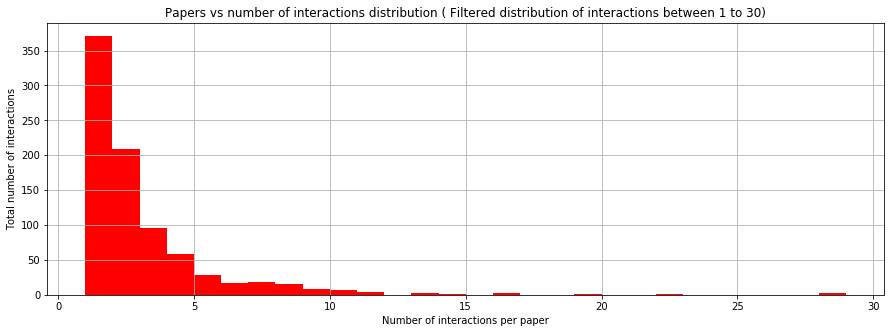

In [10]:
df = data.pubmedId.value_counts().hist (bins=range(1, 30), figsize=(15,5), color = 'red')

plt.title('Papers vs number of interactions distribution ( Filtered distribution of interactions between 1 to 30)')
plt.xlabel('Number of interactions per paper')
plt.ylabel('Total number of interactions')

plt.show()

### Filter out interactions from paper with more than 15 interactions

In [117]:
pubmed_interaction_count = data.pubmedId.value_counts().to_frame().rename(columns={"pubmedId":"interactionCountPerPubmed"})


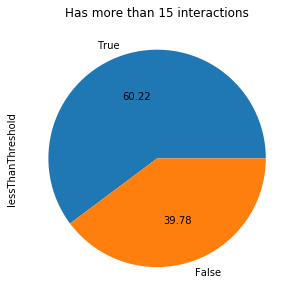

In [118]:
interactions_count= pd.DataFrame()
data["lessThanThreshold"] = data.apply(lambda r: r["pubmedId"] in  pubmed_interaction_count.query('interactionCountPerPubmed <= 15').index , 1)


data.lessThanThreshold.value_counts().plot.pie(autopct='%.2f',figsize=(5, 5))
plt.title('Has more than 15 interactions')
plt.show()

In [120]:
data = data.query("lessThanThreshold == 1")

In [121]:
print("Total number of records after filter: {}".format(data.shape[0]))

Total number of records after filter: 2036


### Interaction Types distribution

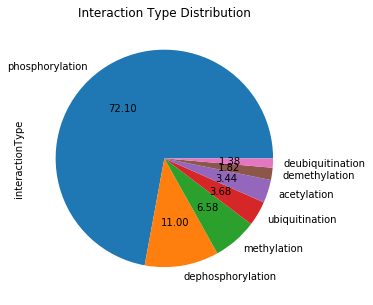

In [15]:
data.interactionType.value_counts().plot.pie(autopct='%.2f',figsize=(5, 5))
plt.title('Interaction Type Distribution')
plt.show()

In [16]:
data.interactionType.value_counts().to_frame()

,interactionType
phosphorylation,1468
dephosphorylation,224
methylation,134
ubiquitination,75
acetylation,70
demethylation,37
deubiquitination,28


### Distinct interaction types per paper

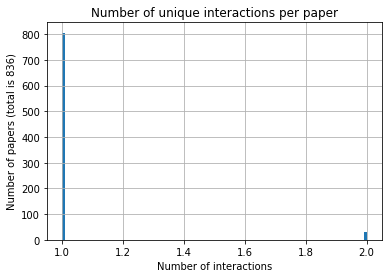

In [17]:
distinct_no_papers = data['pubmedId'].nunique()
data.groupby('pubmedId')['interactionType'].nunique().hist(bins=100)
plt.title("Number of unique interactions per paper")
plt.xlabel('Number of interactions')
plt.ylabel('Number of papers (total is {})'.format(distinct_no_papers))
plt.show()

### Postive vs Negative Relationships

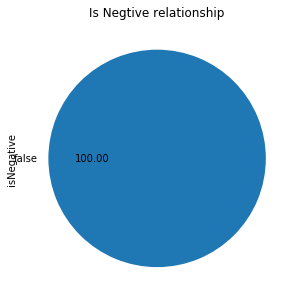

In [18]:
data.isNegative.value_counts().plot.pie(autopct='%.2f',figsize=(5, 5))
plt.title('Is Negtive relationship')
plt.show()

### Number of participants per interaction

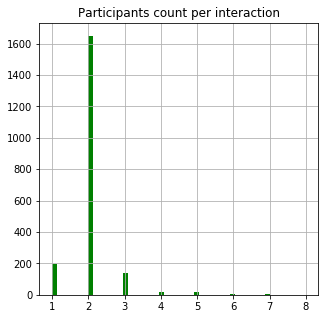

In [19]:
data["participants"].apply(lambda x: len(x)).hist (bins=50, figsize=(5,5), color = 'green')
plt.title("Participants count per interaction")
plt.show()

### Explore if the abstract contains the trigger word

In [20]:
data["hasTriggerWord"] = data.apply(lambda r: r["interactionType"].lower() in r["pubmedabstract"].lower() , 1)

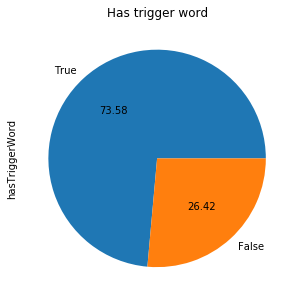

In [21]:
data.hasTriggerWord.value_counts().plot.pie(autopct='%.2f',figsize=(5, 5))
plt.title('Has trigger word')
plt.show()

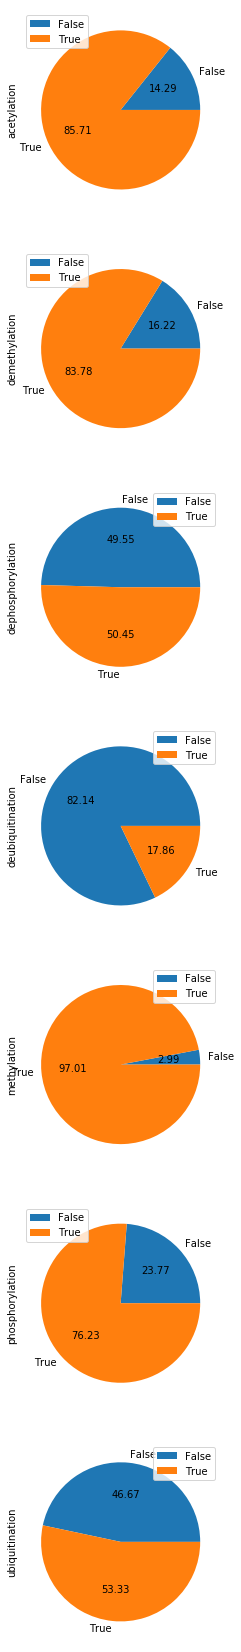

In [ ]:
fig, ax = plt.subplots( 7,1, figsize=(45,30))
data.groupby(['hasTriggerWord', 'interactionType']).size().unstack().plot(kind='pie', subplots='True',autopct='%.2f', ax=ax)
plt.show()

### Explore how many of the entity alias are mentioned in the abstract

In [23]:
%%time 

from difflib import SequenceMatcher
def getEntityMentionsCount(r):
    count = 0
    abstract = r["pubmedabstract"].lower()
    abstract_len= len(abstract)
    for p in r["participants"]:
        if p is None or p['alias'] is None : continue
        
        for a in p['alias']:
            alias = a[0].lower()
            s = SequenceMatcher(None, abstract, alias)
            _,_,match_size = s.find_longest_match(0, len(abstract), 0, len(alias))
            if match_size >= 3 and match_size >= len(alias)/2 :
                count += 1
        
    return count
        

data["entityMentionsCount"] = data.apply(lambda r: getEntityMentionsCount(r)  , 1)

CPU times: user 15.2 s, sys: 67.2 ms, total: 15.3 s
Wall time: 15.4 s


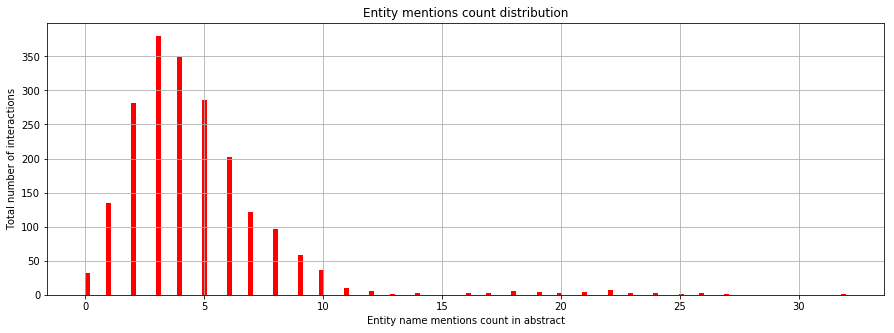

In [24]:
data['entityMentionsCount'].hist ( bins=150, figsize=(15,5), color = 'red')
plt.title('Entity mentions count distribution')
plt.xlabel('Entity name mentions count in abstract')
plt.ylabel('Total number of interactions')

plt.show()

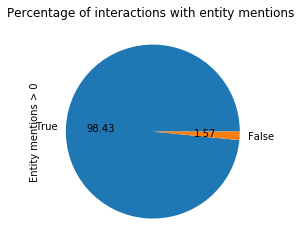

In [25]:
(data['entityMentionsCount'] > 0).value_counts().plot.pie(autopct='%.2f')
plt.title("Percentage of interactions with entity mentions ")
plt.ylabel("Entity mentions > 0")
plt.show()

### Randomly eye ball interactions with no entity mentions

In [26]:

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 10000)
pd.set_option('display.max_rows', 100)

data.query('entityMentionsCount == 0')[['participants','pubmedabstract' ]].sample(n=10)


,participants,pubmedabstract
2214,"[{'uniprotid': 'Q5TCN2', 'alias': [['sgk1_human'], ['Serine/threonine-protein kinase Sgk1'], ['SGK1'], ['SGK'], ['Serum/glucocorticoid-regulated kinase 1']]}, {'uniprotid': 'Q6FI20', 'alias': [['pdpk1_human'], ['3-phosphoinositide-dependent protein kinase 1'], ['PDPK1'], ['PDK1']]}]","NM23-H1 is a member of the NM23/NDP kinase gene family and a putative metastasis suppressor. Previously, a screen for NM23-H1-interacting proteins that could potentially modulate its activity identified serine-threonine kinase receptor-associated protein (STRAP), a transforming growth factor (TGF)-beta receptor-interacting protein. Through the use of cysteine to serine amino acid substitution mutants of NM23-H1 (C4S, C109S, and C145S) and STRAP (C152S, C270S, and C152S/C270S), we demonstrated that the association between these two proteins is dependent on Cys(145) of NM23-H1 and Cys(152) and Cys(270) of STRAP but did not appear to involve Cys(4) and Cys(109) of NM23-H1, suggesting that a disulfide linkage involving Cys(145) of NM23-H1 and Cys(152) or Cys(270) of STRAP mediates complex formation. The interaction was dependent on the presence of dithiothreitol or beta-mercaptoethanol but not H(2)O(2). Ectopic expression of wild-type NM23-H1, but not NM23-H1(C145S), negatively regulated TGF-beta signaling in a dose-dependent manner, enhanced stable association between the TGF-beta receptor and Smad7, and prevented nuclear translocation of Smad3. Similarly, wild-type NM23-H1 inhibited TGF-beta-induced apoptosis and growth inhibition, whereas NM23-H1(C145S) had no effect. Knockdown of NM23-H1 by small interfering RNA stimulated TGF-beta signaling. Coexpression of wild-type STRAP, but not STRAP(C152S/C270S), significantly stimulated NM23-H1-induced growth of HaCaT cells. These results suggest that the direct interaction of NM23-H1 and STRAP is important for the regulation of TGF-beta-dependent biological activity as well as NM23-H1 activity."
1071,"[{'uniprotid': 'Q5TI68', 'alias': [['ks6a2_human'], ['Ribosomal protein S6 kinase alpha-2'], ['RPS6KA2'], ['RSK3'], ['90 kDa ribosomal protein S6 kinase 2'], ['MAPKAPK1C'], ['Ribosomal S6 kinase 3'], ['pp90RSK3'], ['MAP kinase-activated protein kinase 1c']]}, {'uniprotid': 'Q4VBY7', 'alias': [['rs6_human'], ['40S ribosomal protein S6'], ['RPS6'], ['Phosphoprotein NP33'], ['Small ribosomal subunit protein eS6'], ['OK/SW-cl.2']]}]","Patients with small cell lung cancer (SCLC) die because of chemoresistance. Fibroblast growth factor-2 (FGF-2) increases the expression of antiapoptotic proteins, XIAP and Bcl-X(L), and triggers chemoresistance in SCLC cells. Here we show that these effects are mediated through the formation of a specific multiprotein complex comprising B-Raf, PKCepsilon and S6K2. S6K1, Raf-1 and other PKC isoforms do not form similar complexes. RNAi-mediated downregulation of B-Raf, PKCepsilon or S6K2 abolishes FGF-2-mediated survival. In contrast, overexpression of PKCepsilon increases XIAP and Bcl-X(L) levels and chemoresistance in SCLC cells. In a tetracycline-inducible system, increased S6K2 kinase activity triggers upregulation of XIAP, Bcl-X(L) and prosurvival effects. However, increased S6K1 kinase activity has no such effect. Thus, S6K2 but not S6K1 mediates prosurvival/chemoresistance signalling."
963,"[{'uniprotid': 'P49674', 'alias': [['kc1e_human'], ['Casein kinase I isoform epsilon'], ['CSNK1E']]}, {'uniprotid': 'Q15162', 'alias': [['apc_human'], ['Adenomatous polyposis coli protein'], ['APC'], ['DP2.5'], ['Deleted in polyposis 2.5']]}]","Although casein kinase Iepsilon (CKIepsilon) has been shown to regulate the Wnt signaling pathway positively, its mode of action is not clear. In this study we show that CKIepsilon activates the Wnt signaling pathway in co-operation with Dvl. CKIepsilon and Axin associated with different sites of Dvl, and CKIepsilon and Dvl interacted with distinct regions on Axin. Therefore, these three proteins formed a ternary co

In [ ]:
data.head(n=10)

,interactionId,interactionType,isNegative,participants,pubmedId,pubmedTitle,pubmedabstract,lessThanThreshold,hasTriggerWord,entityMentionsCount
0,2503510,phosphorylation,false,"[{'uniprotid': 'P43405', 'alias': [['ksyk_human'], ['Tyrosine-protein kinase SYK'], ['SYK'], ['Spleen tyrosine kinase'], ['p72-Syk']]}]",25605870,None,"NLRP3 is the most crucial member of the NLR family, as it detects the existence of pathogen invasion and self-derived molecules associated with cellular damage. Several studies have reported that excessive NLRP3 inflammasome-mediated caspase-1 activation is a key factor in the development of diseases. Recent studies have reported that Syk is involved in pathogen-induced NLRP3 inflammasome activation; however, the detailed mechanism linking Syk to NLRP3 inflammasome remains unclear. In this study, we showed that Syk mediates NLRP3 stimuli-induced processing of procaspase-1 and the consequent activation of caspase-1. Moreover, the kinase activity of Syk is required to potentiate caspase-1 activation in a reconstituted NLRP3 inflammasome system in HEK293T cells. The adaptor protein ASC bridges NLRP3 with the effector protein caspase-1. Herein, we find that Syk can associate directly with ASC and NLRP3 by its kinase domain but interact indirectly with procaspase-1. Syk can phosphorylate ASC at Y146 and Y187 residues, and the phosphorylation of both residues is critical to enhance ASC oligomerization and the recruitment of procaspase-1. Together, our results reveal a new molecular pathway through which Syk promotes NLRP3 inflammasome formation, resulting from the phosphorylation of ASC. Thus, the control of Syk activity might be effective to modulate NLRP3 inflammasome activation and treat NLRP3-related immune diseases.",True,True,1
1,2503513,phosphorylation,false,"[{'uniprotid': 'P43405', 'alias': [['ksyk_human'], ['Tyrosine-protein kinase SYK'], ['SYK'], ['Spleen tyrosine kinase'], ['p72-Syk']]}, {'uniprotid': 'Q9BSZ5', 'alias': [['asc_human'], ['Apoptosis-associated speck-like protein containing a CARD'], ['PYD and CARD domain-containing protein'], ['Target of methylation-induced silencing 1'], ['Caspase recruitment domain-containing protein 5'], ['ASC'], ['CARD5'], ['TMS1'], ['PYCARD']]}]",25605870,None,"NLRP3 is the most crucial member of the NLR family, as it detects the existence of pathogen invasion and self-derived molecules associated with cellular damage. Several studies have reported that excessive NLRP3 inflammasome-mediated caspase-1 activation is a key factor in the development of diseases. Recent studies have reported that Syk is involved in pathogen-induced NLRP3 inflammasome activation; however, the detailed mechanism linking Syk to NLRP3 inflammasome remains unclear. In this study, we showed that Syk mediates NLRP3 stimuli-induced processing of procaspase-1 and the consequent activation of caspase-1. Moreover, the kinase activity of Syk is required to potentiate caspase-1 activation in a reconstituted NLRP3 inflammasome system in HEK293T cells. The adaptor protein ASC bridges NLRP3 with the effector protein caspase-1. Herein, we find that Syk can associate directly with ASC and NLRP3 by its kinase domain but interact indirectly with procaspase-1. Syk can phosphorylate ASC at Y146 and Y187 residues, and the phosphorylation of both residues is critical to enhance ASC oligomerization and the recruitment of procaspase-1. Together, our results reveal a new molecular pathway through which Syk promotes NLRP3 inflammasome formation, resulting from the phosphorylation of ASC. Thus, the control of Syk activity might be effective to modulate NLRP3 inflammasome activation and treat NLRP3-related immune diseases.",True,True,2
10,1796163,phosphorylation,false,"[{'uniprotid': 'Q8WUB1', 'alias': [['kc1g2_human'], ['Casein kinase I isoform gamma-2'], ['CK1G2'], ['CSNK1G2']]}, {'uniprotid': 'Q6ZS50', 'alias': [['lrrk2_human'], ['Leucine-rich repeat serine/threonine-protein kinase 2'], ['LRRK2'], ['PARK8'], [

Okay.. looks like it is only a case of the names of the participants not matching the names of the alias used in the abstract.. 

### Data Engineering

#### Add more negative samples

In [122]:
import uuid
unique_pubmeds = data["pubmedId"].unique()
data_fake = pd.DataFrame(columns=data.columns)
num_fake_records = int( .30 * len(data))
#TODO: Randomise this, biased via
for u in unique_pubmeds:
    fake_records = pd.DataFrame(data[ data.pubmedId != u]  ) 
    fake_records.loc[:, "interactionId"] = "Fake_" + str(uuid.uuid4() ) + "_" + fake_records.interactionId.astype(str) 
    fake_records.loc[:,"isNegative"] = 'True' 
    ## Copy of the pubmeid abtract and the title from a id
    fake_records.loc[:,"pubmedId"] = u
    fake_records.loc[:, "pubmedTitle"] =  data[ data.pubmedId == u].iloc[0]["pubmedTitle"]
    fake_records.loc[:, "pubmedabstract"] =  data[ data.pubmedId == u].iloc[0]["pubmedabstract"]
    
    
    data_fake = data_fake.append(fake_records, ignore_index=True)
    if len(data_fake) > num_fake_records:
        break
  
    

In [123]:
data_fake.head(n=3)

,interactionId,interactionType,isNegative,participants,pubmedId,pubmedTitle,pubmedabstract,lessThanThreshold
0,Fake_b18816a7-1a7d-4915-94f2-a8c6d67fd4c9_1796163,phosphorylation,True,"[{'uniprotid': 'Q8WUB1', 'alias': [['kc1g2_human'], ['Casein kinase I isoform gamma-2'], ['CK1G2'], ['CSNK1G2']]}, {'uniprotid': 'Q6ZS50', 'alias': [['lrrk2_human'], ['Leucine-rich repeat serine/threonine-protein kinase 2'], ['LRRK2'], ['PARK8'], ['Dardarin']]}]",25605870,None,"NLRP3 is the most crucial member of the NLR family, as it detects the existence of pathogen invasion and self-derived molecules associated with cellular damage. Several studies have reported that excessive NLRP3 inflammasome-mediated caspase-1 activation is a key factor in the development of diseases. Recent studies have reported that Syk is involved in pathogen-induced NLRP3 inflammasome activation; however, the detailed mechanism linking Syk to NLRP3 inflammasome remains unclear. In this study, we showed that Syk mediates NLRP3 stimuli-induced processing of procaspase-1 and the consequent activation of caspase-1. Moreover, the kinase activity of Syk is required to potentiate caspase-1 activation in a reconstituted NLRP3 inflammasome system in HEK293T cells. The adaptor protein ASC bridges NLRP3 with the effector protein caspase-1. Herein, we find that Syk can associate directly with ASC and NLRP3 by its kinase domain but interact indirectly with procaspase-1. Syk can phosphorylate ASC at Y146 and Y187 residues, and the phosphorylation of both residues is critical to enhance ASC oligomerization and the recruitment of procaspase-1. Together, our results reveal a new molecular pathway through which Syk promotes NLRP3 inflammasome formation, resulting from the phosphorylation of ASC. Thus, the control of Syk activity might be effective to modulate NLRP3 inflammasome activation and treat NLRP3-related immune diseases.",True
1,Fake_b18816a7-1a7d-4915-94f2-a8c6d67fd4c9_1160297,phosphorylation,True,"[{'uniprotid': None, 'alias': None}, {'uniprotid': 'Q05BV0', 'alias': [['akt2_human'], ['RAC-beta serine/threonine-protein kinase'], ['AKT2'], ['RAC-PK-beta'], ['Protein kinase Akt-2'], ['Protein kinase B beta']]}]",25605870,None,"NLRP3 is the most crucial member of the NLR family, as it detects the existence of pathogen invasion and self-derived molecules associated with cellular damage. Several studies have reported that excessive NLRP3 inflammasome-mediated caspase-1 activation is a key factor in the development of diseases. Recent studies have reported that Syk is involved in pathogen-induced NLRP3 inflammasome activation; however, the detailed mechanism linking Syk to NLRP3 inflammasome remains unclear. In this study, we showed that Syk mediates NLRP3 stimuli-induced processing of procaspase-1 and the consequent activation of caspase-1. Moreover, the kinase activity of Syk is required to potentiate caspase-1 activation in a reconstituted NLRP3 inflammasome system in HEK293T cells. The adaptor protein ASC bridges NLRP3 with the effector protein caspase-1. Herein, we find that Syk can associate directly with ASC and NLRP3 by its kinase domain but interact indirectly with procaspase-1. Syk can phosphorylate ASC at Y146 and Y187 residues, and the phosphorylation of both residues is critical to enhance ASC oligomerization and the recruitment of procaspase-1. Together, our results reveal a new molecular pathway through which Syk promotes NLRP3 inflammasome formation, resulting from the phosphorylation of ASC. Thus, the control of Syk activity might be effective to modulate NLRP3 inflammasome activation and treat NLRP3-related immune diseases.",True
2,Fake_b18816a7-1a7d-4915-94f2-a8c6d67fd4c9_1160335,phosphorylation,True,"[{'uniprotid': 'B7Z5R1', 'alias': [['akt1_human'], ['RAC-alpha serine/threonine-protein kinase'], ['AKT1'], ['PKB'], ['RAC'], ['RAC-PK-alpha'], ['Protein kinase B'], ['Proto-oncogene c-Akt'], ['Protein kinase B alpha']]}, {'uniprotid': 'Q9NTM3', 'alias': [['vime_human'

In [125]:
data_final = data.append(data_fake, ignore_index=True)
print("The total number of records including fake records {}".format(data_final.shape[0]))

The total number of records including fake records 4069


In [128]:
data_final = data_final.drop('lessThanThreshold' , axis=1)

In [129]:
data_final.to_json("formatteddata.json")